## Problem Statement
A Chinese automobile company Geely Auto aspires to enter the US market by setting up their manufacturing unit there and producing cars locally to give competition to their US and European counterparts.

They have contracted an automobile consulting company to understand the factors on which the pricing of cars depends. Specifically, they want to understand the factors affecting the pricing of cars in the American market, since those may be very different from the Chinese market. The company wants to know:

- **Which variables are significant in predicting the price of a car**
- **How well those variables describe the price of a car**

Based on various market surveys, the consulting firm has gathered a large data set of different types of cars across the America market.

## Business Goal
We are required to model the price of cars with the available independent variables. It will be used by the management to understand how exactly the prices vary with the independent variables. They can accordingly manipulate the design of the cars, the business strategy etc. to meet certain price levels. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

**Note**: I will be following along with the following notebook 

https://www.kaggle.com/hellbuoy/car-price-prediction

---

# Step 1: Reading the data
### Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from math import floor, ceil
from statistics import mean

Machine learning modules

In [2]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [3]:
random_state = 0
%matplotlib inline

#### Helper functions

In [4]:
def process_linear_regression(df, x_factor, y_factor):
    global significant_factors
    
    x_data = np.array(df[x_factor]).reshape((-1, 1))
    y_data = df[y_factor]
    model = LinearRegression().fit(x_data, y_data)
    r_squared = model.score(x_data, y_data)
    slope = model.coef_
    y_intercept = model.intercept_
    x_fit = range(101)
    y_fit = [(slope * x + y_intercept) for x in x_fit]
    
    X2 = sm.add_constant(x_data)
    est = sm.OLS(y_data, X2)
    est2 = est.fit()
    p_value = est2.pvalues[1]
    p_value_formatted = format(p_value, '.8f')
        
    return slope[0], y_intercept, r_squared, p_value, p_value_formatted

In [5]:
def line_of_best_fit(x_data, y_data, title):
    x_fit = range(max(x_data))
    x_data = np.array(x_data.reshape((-1, 1)))
    model = LinearRegression().fit(x_data, y_data)
    r_squared = r2_score(x_data, y_data)
    slope = model.coef_
    y_intercept = model.intercept_
    y_fit = [(slope * x + y_intercept) for x in x_fit]
    
    plt.scatter(x_data, y_data)
    plt.plot(x_fit, y_fit, c = "g")
    plt.title(f"{title}\nR squared = {round(r_squared,2)}")

### Read data from csv

In [6]:
csv_file = "CarPrice_Assignment.csv"
data = pd.read_csv(csv_file)
data.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

**Oberservations**
- There is no missing data
- Most data is numerical

<br>

---

# Step 2: Cleaning the data

The ID number for each car is not needed. It doesn't contribute towards the price and if we need to differentiate between specific cars we can use the index number

In [8]:
data = data.drop('car_ID',axis=1)

In [9]:
# changing the datatype of symboling as it is categorical variable as per dictionary file

data['symboling'] = data['symboling'].astype(str)

The individual model of the car will not be useful in creating a generalised model for predicting price. It may be useful to retain the brand of car so that we can compare between luxury brands and economy brands. We will be dropping everything after the first space in the name

In [10]:
data["CarName"] = data.CarName.str.split(" ", expand=True)

In [11]:
for brand in data.CarName.unique():
    print(brand)

alfa-romero
audi
bmw
chevrolet
dodge
honda
isuzu
jaguar
maxda
mazda
buick
mercury
mitsubishi
Nissan
nissan
peugeot
plymouth
porsche
porcshce
renault
saab
subaru
toyota
toyouta
vokswagen
volkswagen
vw
volvo


**Observations**

It is clear that there are a number of typo errors in the data
- maxda = mazda
- Nissan = nissan
- porsche = porcshce
- toyota = toyouta
- vokswagen = volkswagen = vw

These should be fixed before we continue

In [12]:
data['CarName'] = data['CarName'].replace(
    {
        'maxda': 'mazda', 
        'nissan': 'Nissan', 
        'porcshce': 'porsche', 
        'toyouta': 'toyota', 
        'vokswagen': 'volkswagen', 
        'vw': 'volkswagen'
    }
)

### Question: Is it more useful to keep cylinder number as categorical data or convert it numeric? 

##### Convert the data to numeric

In [13]:
exploration_df = data.copy()
exploration_df['cylindernumber'] = exploration_df['cylindernumber'].replace(
    {
        'four': 4, 
        'six': 6, 
        'five': 5, 
        'three': 3, 
        'twelve': 12, 
        'two': 2,
        "eight": 8
    }
)

In [14]:
exploration_df[["cylindernumber","price"]].groupby(by = "cylindernumber").count()

,price
cylindernumber,
2,4
3,1
4,159
5,11
6,24
8,5
12,1


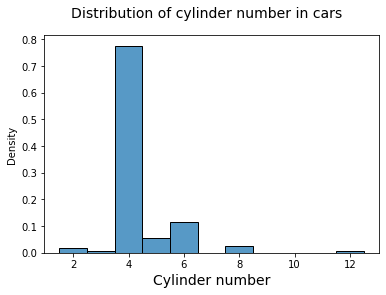

In [15]:
fig = plt.figure()
sns.histplot(
    exploration_df["cylindernumber"],
    stat="density",
    bins = range(2,14),
    discrete = True # centres bars on data
)
fig.suptitle('Distribution of cylinder number in cars', fontsize = 14)                   
plt.xlabel('Cylinder number', fontsize = 14);

#### Observations:

- Most cars (77.6%) have four cylinders
- Some cars (11.7%) have six cylinders
- Only one car has three cylinders and only one has twelve
   - This could skew predictions due to insufficient data

#### A scatter graph shows the true distance between numbers of cylinders. 

This is what we would see if the data is numeric. It would appear that the cost of a car does not strictly scale linearly with the number of cylinders or we would expect that the value of a 12 cylinder car would be much higher. However, it is worth noting that there is only one data point for 12 cylinder cars and it is possible that this is an outlier with the majority being more valuable

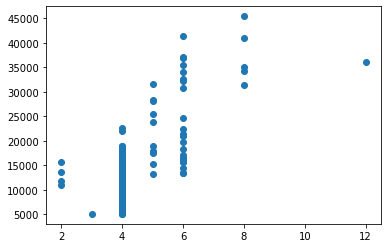

In [16]:
plt.scatter(exploration_df["cylindernumber"], exploration_df["price"]);

##### What would we predict a 12 cylinder car to cost if we didn't have that data point

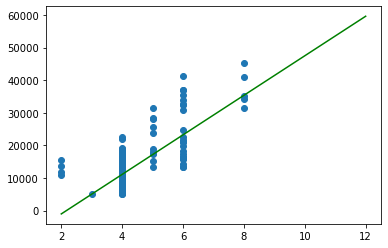

In [17]:
mask = exploration_df["cylindernumber"] < 10
filtered_df = exploration_df[mask]

slope, y_intercept, r_squared, p_value, p_value_formatted = process_linear_regression(filtered_df, "cylindernumber", "price")
x_fit = range(2, 13)
y_fit = [(slope * x + y_intercept) for x in x_fit]

plt.scatter(filtered_df["cylindernumber"], filtered_df["price"])
plt.plot(x_fit, y_fit, ("g" if p_value < 0.05 else "r")) ;

In [18]:
print("The cost of a 12 cylinder car is predicted to be $" + str(round(slope * 12 + y_intercept,2)))

The cost of a 12 cylinder car is predicted to be $59592.31


##### A boxplot shows categorical data

This is representative of what we would see if the data was left in string format and ordered. Note how 8 is directly next to 6 and 12 is next to 8. This does show a more linear increase than the scatter graph where the increase in price with more cylinders tapers off more quickly. This could be a fairer depiction of the market reality where 11 cylinder cars might not exist and it's not relevant including them in data.

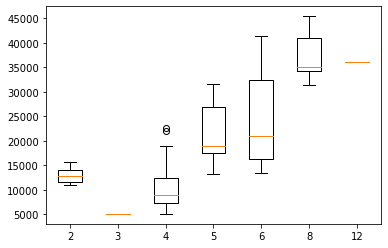

In [19]:
boxplot_data = []
labels = sorted(exploration_df["cylindernumber"].unique())
for number_of_cylinders in labels:
    mask = exploration_df["cylindernumber"] == number_of_cylinders
    filtered_df = exploration_df[mask]
    boxplot_data.append(filtered_df["price"])

plt.boxplot(boxplot_data, labels = labels);
# boxplot_data

#### Observations

- Less than 3% of cars sold have more than 6 cylinders with only one singular car having twelve
- From the scatter chart it is clear that the value of car does not scale linearly with the number of cylinders. Without the data point from the 12 cylinder car, we would expect a 12 cylinder car to cost almost 60000 when in reality it only costs 36000, just 60% of its predicted value.
- However, having 8+ cylinders appears to be a good predictor of high car value and having <4 is a good predictor of low value. It may be useful to keep the data as categorical but merge similar categories together. This would also help to even out the number of data points in each category.

#### Decision

Keep the data as categorical but merge the smallest two and the largest two into a more general category

In [20]:
data['cylindernumber'] = data['cylindernumber'].replace(
    {
        'four': "4", 
        'six': "6", 
        'five': "5",
        'three': "3 or fewer", 
        'twelve': "8+", 
        'two': "3 or fewer",
        "eight": "8+"
    }
)

In [21]:
data[["cylindernumber","price"]].groupby(by = "cylindernumber").count()

,price
cylindernumber,
3 or fewer,5
4,159
5,11
6,24
8+,6


<br>

---

#### Segregating Numerical and Categorical Variables

In [22]:
cat_col = data.select_dtypes(include=['object']).columns
num_col = data.select_dtypes(exclude=['object']).columns
df_cat = data[cat_col]
df_num = data[num_col]

<br>

---

# Step 3: Visualising the data

We will identify which predictors have a strong assoiation variable `price`

#### Distribution of car brands

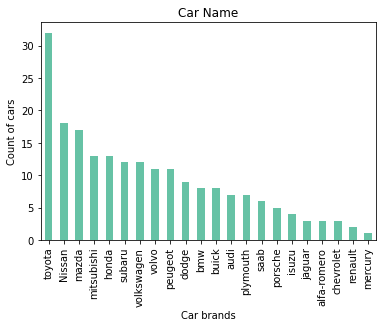

In [23]:
ax = data["CarName"].value_counts().plot(
    kind="bar", 
    stacked=True,
    colormap = "Set2"
)
ax.title.set_text("Car Name")
plt.xlabel("Car brands")
plt.ylabel("Count of cars");

**Insights**
- Toyota is by far the most popular car
- Mercury is the least popular brand of car

#### Distribution of car prices

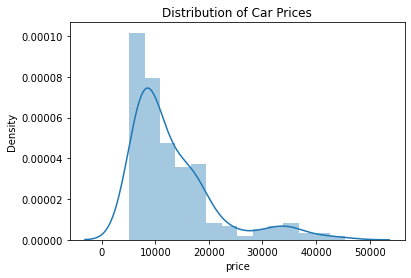

In [24]:
plt.title("Distribution of Car Prices")
sns.distplot(data.price);

In [25]:
data.price.describe()

count      205.000000
mean     13276.710571
std       7988.852332
min       5118.000000
25%       7788.000000
50%      10295.000000
75%      16503.000000
max      45400.000000
Name: price, dtype: float64

**Insights**
- 75% of cars cost 5,000 - 16,500
- There is some skew towards more expensive cars - there more expensive outliers but no cheap outliers

### Identifying significant numerical factors

This produces a grid of scatter graphs for every combination of numerical factor with `price`. The R squared and p-values are calculated and the line of best fit is plotted. 

The line of best fit is coloured:

$$\text{green if significant} \hspace{1cm} p<0.05$$

$$\text{red if not significant} \hspace{1cm} p\leq0.05$$.

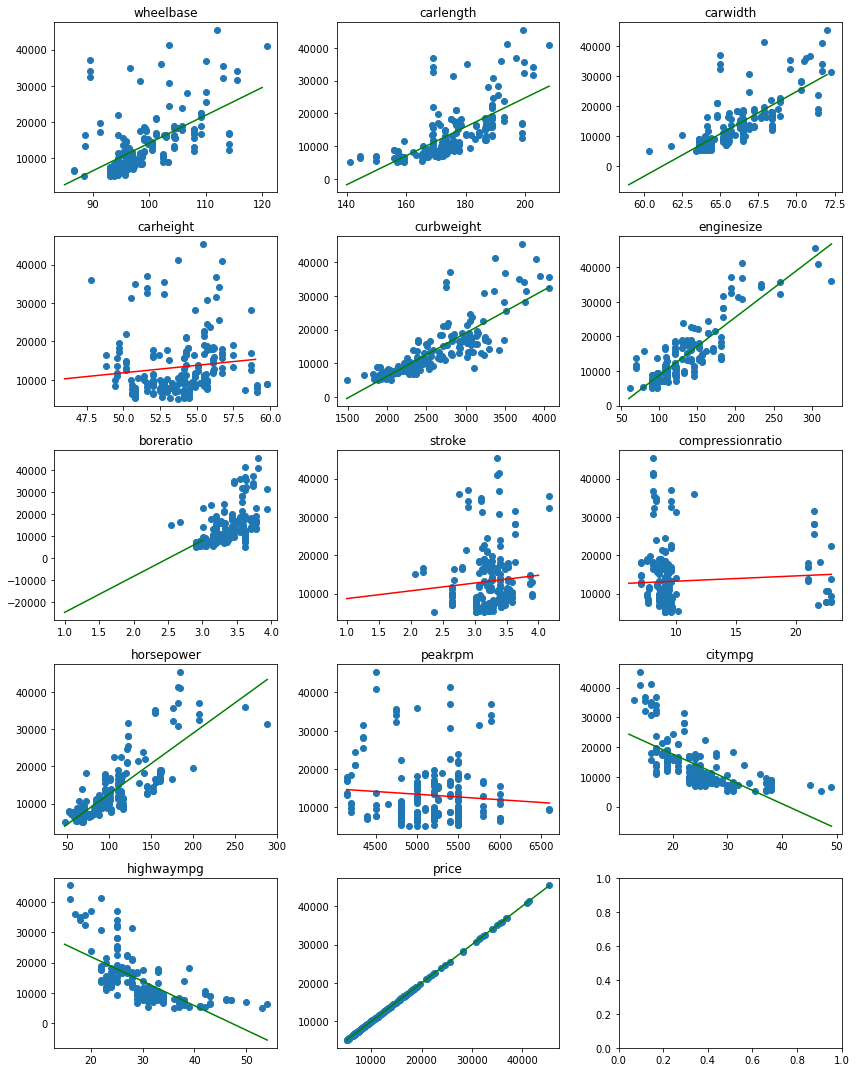

In [26]:
sig_num_factors = {}
fig, axs = plt.subplots(5, 3, figsize=(12,15))

for i, factor in enumerate(df_num.columns):
    counter = i
    row = floor(counter/3)
    column = i-(row*3)
    
    slope, y_intercept, r_squared, p_value, p_value_formatted = process_linear_regression(df_num, factor, "price")
    x_fit = range(int(df_num[factor].min()-1), int(df_num[factor].max())+1)
    y_fit = [(slope * x + y_intercept) for x in x_fit]

    axs[row, column].scatter(df_num[factor], df_num["price"])
    axs[row, column].plot(x_fit, y_fit, ("g" if p_value < 0.05 else "r")) 
    # green if significant
    axs[row, column].set_title(factor)
    
    if p_value < 0.05:
        sig_num_factors[factor] = [slope, y_intercept, r_squared, p_value]

plt.tight_layout()

In [27]:
significant_df = pd.DataFrame.from_dict(
    sig_num_factors, 
    orient="index", 
    columns = ["Slope", "y intercept", "R squared", "p value"]
)

significant_df.drop("price", inplace = True)

significant_df["relationship"] = significant_df["Slope"] > 0
significant_df["relationship"] = significant_df["relationship"].replace(
    {
        True: 'Positive', 
        False: 'Negative'
    }
)

significant_df.sort_values(by="R squared", ascending = False)

,Slope,y intercept,R squared,p value,relationship
enginesize,167.698416,-8005.445531,0.764129,1.354764e-65,Positive
curbweight,12.816173,-19475.862380,0.697734,1.214445e-54,Positive
horsepower,163.263061,-3721.761494,0.653088,1.483437e-48,Positive
carwidth,2827.767479,-173095.236704,0.576575,9.627438e-40,Positive
highwaympg,-809.273528,38162.858484,0.486644,3.230681e-31,Negative
citympg,-837.396445,34395.440416,0.470255,7.978684e-30,Negative
carlength,442.216063,-63690.671612,0.466380,1.678707e-29,Positive
wheelbase,766.565168,-62426.647883,0.333871,1.182820e-19,Positive
boreratio,16316.492553,-41053.229999,0.306001,7.907922e-18,Positive


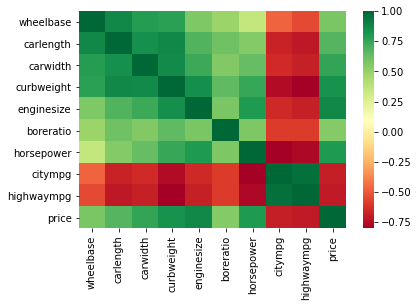

In [28]:
significant_factors_list = list(sig_num_factors.keys())

sns.heatmap(df_num[significant_factors_list].corr(), cmap = "RdYlGn");

#### Observations:

- `enginesize` alone has an R squared value of 0.76 meaning that this one factor can "explain" 76% of the variation in price
- `citympg` and `highwaympg` are the only factors with a negative correlation with `price`.
   - They also negatively correlate with all the other significant factors
   - This can be explained by the factors which increase price reducing the fuel efficiency of the vehicle. As the `carwidth`, `carlength`, `enginesize` etc increases, the car becomes heavier and needs more fuel to move it.
- Some of the graphs could be better explained using a curved line. I should learn about more ways of finding lines of best fit

### Visualising Categorical Variables

In [29]:
factors = df_cat.columns
factors

Index(['symboling', 'CarName', 'fueltype', 'aspiration', 'doornumber',
       'carbody', 'drivewheel', 'enginelocation', 'enginetype',
       'cylindernumber', 'fuelsystem'],
      dtype='object')

In [30]:
temp_df = pd.concat([df_cat, df_num["price"]], axis = 1)

In [31]:
def make_boxplot(df, factor1, factor2):
    sns.boxplot(x = df[factor1].sort_values(ascending = True), y = df[factor2])
    plt.title(f"Relationship between {factor1} and {factor2}")

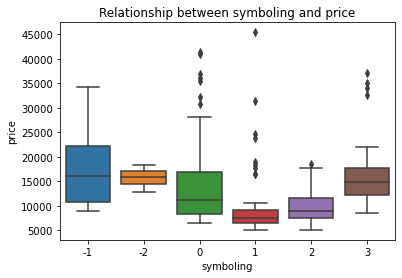

In [32]:
make_boxplot(temp_df, factors[0], "price");

**Observation**

- This doesn't look like it will be very helpful in consistently predicting the price of a car. The most valuable cars are all outliers in categories with a relatively low mean

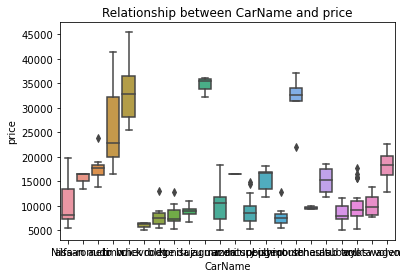

In [33]:
make_boxplot(temp_df, factors[1], "price");

**Observation**
- This is very cluttered but could be interesting to explore separately
- I had initially thought that the brand of a car would be unimportant just like the specific model name was discarded. *A rose by any other name would smell as sweet*. However, I'm interested in seeing if brand loyalty / prestige could result in a car with lower specifications being given a higher price.

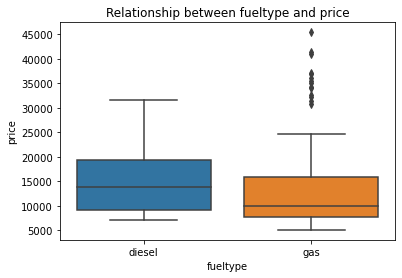

In [34]:
make_boxplot(temp_df, factors[2], "price");

**Observations**
- Cars that run on disel are relatively more expensive than their gas counterparts
- Cars that run on gas have more outliers with a very high price

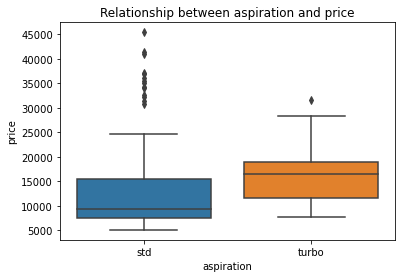

In [35]:
make_boxplot(temp_df, factors[3], "price");

**Observations**
- Cars with turbo aspiration have a much higher mean price
- Cars with standard aspiration have more high price outliers

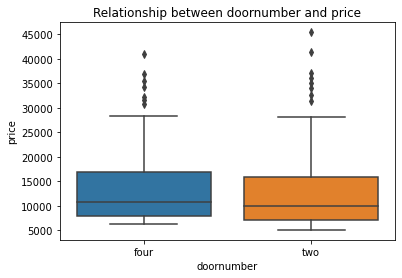

In [36]:
make_boxplot(temp_df, factors[4], "price");

**Observations**
- There is very little difference in price variation between cars with two doors and cars with four doors
- This would not be a helpful factor in our prediction model

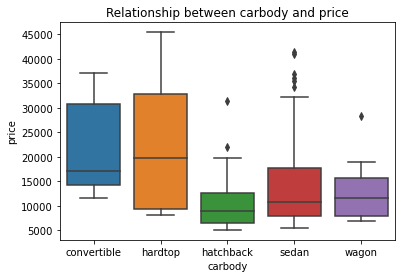

In [37]:
make_boxplot(temp_df, factors[5], "price");

**Observations**
- Convertible and hardtop cars are more expensive than other types

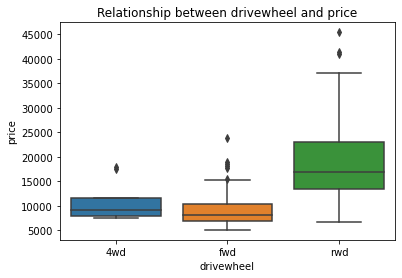

In [38]:
make_boxplot(temp_df, factors[6], "price");

**Observations**
- High end cars have rear wheel drive
- This is a very useful factor for our model

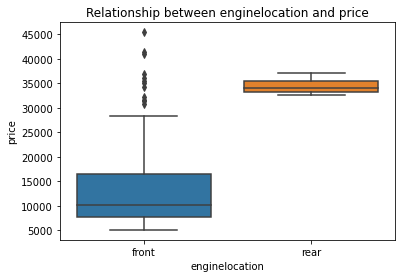

In [39]:
make_boxplot(temp_df, factors[7], "price");

**Observations**
- High end cars tend to have their engines located at the rear
- This is a very useful factor for our model

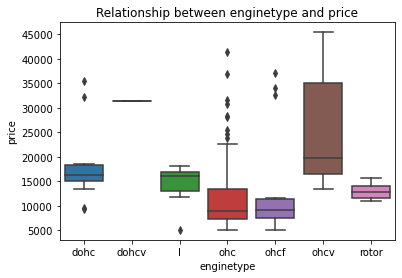

In [40]:
make_boxplot(temp_df, factors[8], "price");

**Observations**
- Most engine types have a relatively small range of prices making them reasonably useful for predicting price
- ohcv has the highest mean but also a much wider range

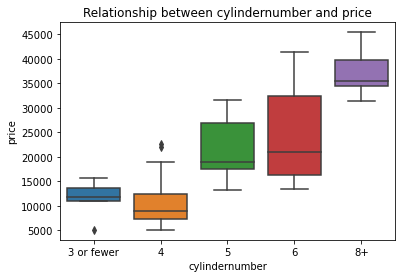

In [41]:
make_boxplot(temp_df, factors[9], "price");

**Observations**
- Cylinder number is a very good predictor of price
- This is a very useful factor for our model

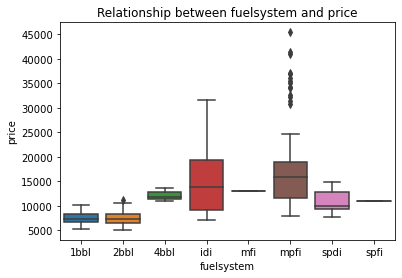

In [42]:
make_boxplot(temp_df, factors[10], "price");

**Observations**
- All of the most expensive cars have a mpfi fuel system
- If a car has a 1bbl, 2bbl, 4bbl, mfi, spdi or spfi fuel system we can be reasonably confident that the car costs <15000

In [43]:
sig_num_features = significant_factors_list
sig_cat_features = [
    "fueltype",
    "carbody",
    "aspiration",
    "enginelocation",
    "cylindernumber",
    "enginetype",
    "drivewheel",
    "fuelsystem"
]

<br>

---

# Step 4:

### Dummy Variables

We need to convert categorical variables to numeric

In [44]:
dummies = pd.get_dummies(data[sig_cat_features])
dummies.shape

(205, 34)

In [45]:
dummies.head()

,fueltype_diesel,fueltype_gas,carbody_convertible,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,aspiration_std,aspiration_turbo,enginelocation_front,...,drivewheel_fwd,drivewheel_rwd,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi
0,0,1,1,0,0,0,0,1,0,1,...,0,1,0,0,0,0,0,1,0,0
1,0,1,1,0,0,0,0,1,0,1,...,0,1,0,0,0,0,0,1,0,0
2,0,1,0,0,1,0,0,1,0,1,...,0,1,0,0,0,0,0,1,0,0
3,0,1,0,0,0,1,0,1,0,1,...,1,0,0,0,0,0,0,1,0,0
4,0,1,0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0


#### Combine the dummy variables with the original dataframe and drop the now redundant categorical features

In [46]:
data = pd.concat([data, dummies], axis = 1)
data.drop(sig_cat_features, axis = 1, inplace = True)
data.drop(["CarName", "doornumber"], axis = 1, inplace = True)
data.head()

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,...,drivewheel_fwd,drivewheel_rwd,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi
0,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,...,0,1,0,0,0,0,0,1,0,0
1,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,...,0,1,0,0,0,0,0,1,0,0
2,1,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,...,0,1,0,0,0,0,0,1,0,0
3,2,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,...,1,0,0,0,0,0,0,1,0,0
4,2,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,...,0,0,0,0,0,0,0,1,0,0


<br>

---

# Step 5: Splitting Data into Training and Testing Sets

In [47]:
inputs = data.drop(["price"], axis=1)
output = data["price"]

X_train, X_test, y_train, y_test = train_test_split(inputs, output, test_size=0.2, random_state = random_state)

#### Normalise the data

When normalising the test set, one should apply the normalisation parameters *previously obtained* from the training set as-is. **Do not recalculate** them on the test set, because they would be inconsistent with the model and this would produce wrong predictions.

Worth noting that `scaler.fit_transform` is used on the training set, then `scaler.transform` is used on the test set 

**Note**: We *don't* want to normalise the dummy variables

In [48]:
cols_to_change = sig_num_features.copy()
cols_to_change.remove("price")

y_train = y_train.astype("int")
y_test = y_test.astype("int")

normalised_X_train = X_train.copy()
train_features = normalised_X_train[cols_to_change] # slice of df that we want to change
scaler = StandardScaler().fit(train_features.values) # create a scaler based on TRAINING data
train_features = scaler.transform(train_features.values) # transform training data
normalised_X_train[cols_to_change] = train_features # apply new values to df

normalised_X_test = X_test.copy() 
test_features = normalised_X_test[cols_to_change] # slice we want to change
test_features = scaler.transform(test_features.values) # use original scaler
normalised_X_test[cols_to_change] = test_features # apply changes

# info about normalising to avoid data leakage
# https://datascience.stackexchange.com/questions/54908/data-normalization-before-or-after-train-test-split

# info about transforming PART of a df
# https://stackoverflow.com/questions/38420847/apply-standardscaler-to-parts-of-a-data-set

#### Which features (numerical and categorical) correlate highly with price?

In [49]:
full_training_data = normalised_X_train.copy()
full_training_data = full_training_data.join(y_train)
full_training_data.corr()["price"].abs().sort_values(ascending = False).head(15)

price               1.000000
enginesize          0.870483
curbweight          0.838867
horsepower          0.814996
carwidth            0.755427
cylindernumber_4    0.734377
highwaympg          0.706518
citympg             0.689439
carlength           0.688922
drivewheel_rwd      0.646885
drivewheel_fwd      0.610127
wheelbase           0.574537
boreratio           0.526800
fuelsystem_mpfi     0.519258
fuelsystem_2bbl     0.505307
Name: price, dtype: float64

<br>

---

# Step 6a: Building a Linear Regression Model

#### Build the model

#### Use Recursive Feature Elimination to identify 10 features which are likely to be important to the model

In [50]:
model = LinearRegression()
rfe = RFE(model, 10)
rfe = rfe.fit(normalised_X_train,y_train)

In [51]:
chosen_columns = normalised_X_train.columns[rfe.support_]
for col in chosen_columns:
    print(col)

curbweight
stroke
carbody_convertible
enginelocation_front
enginelocation_rear
cylindernumber_4
cylindernumber_5
cylindernumber_8+
enginetype_ohc
enginetype_ohcv


#### Train the model using the features identified

In [52]:
model = sm.OLS(y_train, normalised_X_train[chosen_columns], random_state = random_state).fit()
y_train_pred = model.predict(normalised_X_train[chosen_columns])
y_test_pred = model.predict(normalised_X_test[chosen_columns])

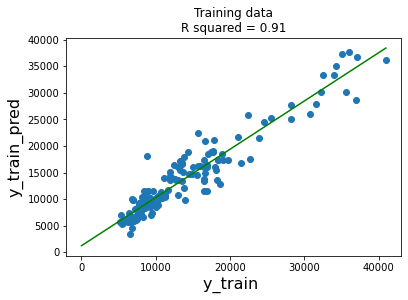

In [53]:
line_of_best_fit(np.array(y_train).astype(int), np.array(y_train_pred).astype(int), "Training data")
plt.xlabel('y_train ', fontsize=16)                       
plt.ylabel('y_train_pred', fontsize=16);

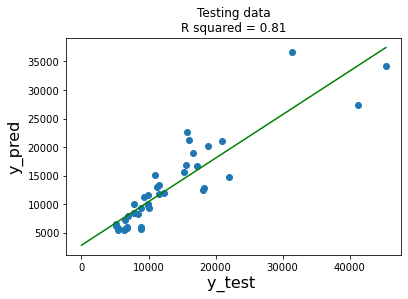

In [54]:
line_of_best_fit(np.array(y_test).astype(int), np.array(y_test_pred).astype(int), "Testing data")
plt.xlabel('y_test ', fontsize=16)                       
plt.ylabel('y_pred', fontsize=16);

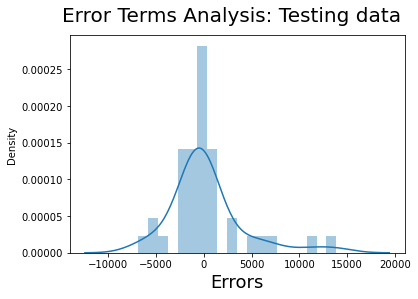

In [55]:
fig = plt.figure()
sns.distplot((y_test - y_test_pred), bins = 20)
fig.suptitle('Error Terms Analysis: Testing data', fontsize = 20)                   
plt.xlabel('Errors', fontsize = 18);

### Evaluating the model

In [56]:
repeats = 15
list_training_error = []
list_testing_error = []
r_squared_train = []
r_squared_test = []

for i in range(repeats):
    X_train, X_test, y_train, y_test = train_test_split(inputs, output, test_size=0.2)
    
    y_train = y_train.astype("int")
    y_test = y_test.astype("int")

    normalised_X_train = X_train.copy()
    train_features = normalised_X_train[cols_to_change] # slice of df that we want to change
    scaler = StandardScaler().fit(train_features.values) # create a scaler based on TRAINING data
    train_features = scaler.transform(train_features.values) # transform training data
    normalised_X_train[cols_to_change] = train_features # apply new values to df

    normalised_X_test = X_test.copy() 
    test_features = normalised_X_test[cols_to_change] # slice we want to change
    test_features = scaler.transform(test_features.values) # use original scaler
    normalised_X_test[cols_to_change] = test_features # apply changes
    
    model = sm.OLS(y_train, normalised_X_train[chosen_columns]).fit()
    y_train_pred = model.predict(normalised_X_train[chosen_columns])
    y_test_pred = model.predict(normalised_X_test[chosen_columns])
    
    R_train = r2_score(y_train,y_train_pred)
    R_test = r2_score(y_test,y_test_pred)
    train_error = mean_absolute_error(y_train,y_train_pred) 
    test_error = mean_absolute_error(y_test,y_test_pred)
    
    r_squared_train.append(R_train)
    r_squared_test.append(R_test)
    list_training_error.append(train_error)
    list_testing_error.append(test_error)
    
train_error = round(mean(list_training_error))
test_error = round(mean(list_testing_error))
r_train = round(mean(r_squared_train),2)
r_test = round(mean(r_squared_test),2)

<br>

**Note**: It is important to test the model several times and then take the average because with a single data point it is impossible to tell if the R Squared score or the Mean Absolute Error is unusually high or low. For example, here are the most extreme values found:

<br>

In [57]:
print("\nTraining set: (R Squared)", round(min(r_squared_train),2), "-", round(max(r_squared_train),2))
print("Testing set: (R Squared)", round(min(r_squared_test),2), "-", round(max(r_squared_test),2), "\n")


Training set: (R Squared) 0.88 - 0.91
Testing set: (R Squared) 0.58 - 0.9 



In [58]:
print(f"""TRAINING SET DATA (on average):
R Squared: {r_train}
Mean Absolute Error: {train_error}

TESTING SET DATA (on average):
R Squared: {r_test}
Mean Absolute Error: {test_error}
""")

TRAINING SET DATA (on average):
R Squared: 0.89
Mean Absolute Error: 1797

TESTING SET DATA (on average):
R Squared: 0.83
Mean Absolute Error: 1942



Using the Linear Regression model and the features identified by Recursive Feature Elimination, we have achieved an average R squared score of 0.89 for the training data and 0.84 for the test data. These scores are close together, suggesting that there isn't a great deal of overfitting or underfitting of the model. Unfortunately, the accuracy is lower than we might like. For that reason, I will repeat the process using a different regression model.

<br>

---

# Step 6: Building a Random Forest Regressor Model

### Pros of Random Forest Regressor:
- You don't need to scale data
- You often don't need to remove outliers
- It'll probably be more accurate

### When to use Linear Regression
- When the underlying function is truly linear
- When there are a very large number of features, especially with very low signal to noise ratio. RF’s have a little trouble modeling linear combinations of a large number of features.
- When covariate shift is likely

In [59]:
model=RandomForestRegressor(n_estimators=100)
model.fit(X_train,y_train)
y_train_pred=model.predict(X_train)
y_test_pred=model.predict(X_test)

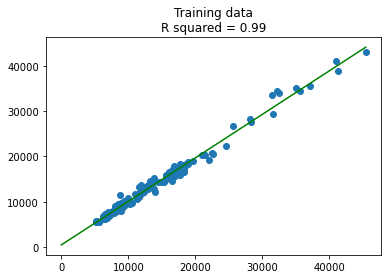

In [60]:
line_of_best_fit(np.array(y_train).astype(int), np.array(y_train_pred).astype(int), "Training data")

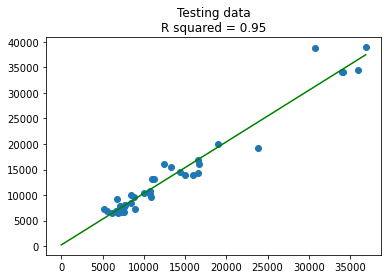

In [61]:
line_of_best_fit(np.array(y_test).astype(int), np.array(y_test_pred).astype(int), "Testing data")

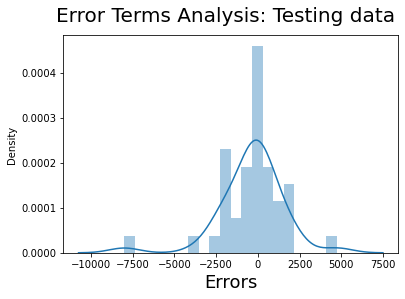

In [62]:
fig = plt.figure()
sns.distplot((y_test - y_test_pred), bins = 20)
fig.suptitle('Error Terms Analysis: Testing data', fontsize = 20)                   
plt.xlabel('Errors', fontsize = 18);

In [63]:
importance = model.feature_importances_
importance_df = pd.DataFrame(list(zip(normalised_X_train.columns,importance)))
mini_df = importance_df.sort_values(by=1, ascending = False).head(10)

### Evaluation of model

In [64]:
repeats = 15
list_training_error = []
list_testing_error = []
r_squared_train = []
r_squared_test = []

for i in range(repeats):
    X_train, X_test, y_train, y_test = train_test_split(inputs, output, test_size=0.2)
    model=RandomForestRegressor(n_estimators=100)
    model.fit(X_train,y_train)
    y_train_pred=model.predict(X_train)
    y_test_pred=model.predict(X_test)
    
    R_train = r2_score(y_train,y_train_pred)
    R_test = r2_score(y_test,y_test_pred)
    train_error = mean_absolute_error(y_train,y_train_pred) 
    test_error = mean_absolute_error(y_test,y_test_pred)
    
    r_squared_train.append(R_train)
    r_squared_test.append(R_test)
    list_training_error.append(train_error)
    list_testing_error.append(test_error)
    
train_error = round(mean(list_training_error))
test_error = round(mean(list_testing_error))
r_train = round(mean(r_squared_train),2)
r_test = round(mean(r_squared_test),2)

<br>

**Note**: It is important to test the model several times and then take the average because with a single data point it is impossible to tell if the R Squared score or the Mean Absolute Error is unusually high or low. For example, here are the most extreme values found:

<br>

In [65]:
print("\nTraining set: (R Squared)", round(min(r_squared_train),2), "-", round(max(r_squared_train),2))
print("Testing set: (R Squared)", round(min(r_squared_test),2), "-", round(max(r_squared_test),2), "\n")


Training set: (R Squared) 0.99 - 0.99
Testing set: (R Squared) 0.82 - 0.96 



In [66]:
print(f"""TRAINING SET DATA (on average):
R Squared: {r_train}
Mean Absolute Error: {train_error}

TESTING SET DATA (on average):
R Squared: {r_test}
Mean Absolute Error: {test_error}
""")

TRAINING SET DATA (on average):
R Squared: 0.99
Mean Absolute Error: 584

TESTING SET DATA (on average):
R Squared: 0.9
Mean Absolute Error: 1600



Using the Random Forest Regression model, we have achieved an R squared score of 0.99 for the training data and 0.90 for the test data. The accuracy is higher than the linear model even for the unseen test data. It can explain 90% of the variation in the price of a car.

# Step 7: Answering the Problem Statement

### Which variables are significant in predicting the price of a car

In [67]:
importance = model.feature_importances_
importance_df = pd.DataFrame(list(zip(normalised_X_train.columns,importance)))
mini_df = importance_df.sort_values(by=1, ascending = False).head(10)

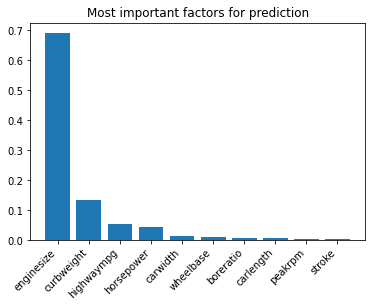

In [68]:
plt.bar(mini_df[0], mini_df[1])
plt.xticks(rotation = 45, ha="right")
plt.title("Most important factors for prediction");

According to our model, the ten **most important features** for predicting the price of a car are:
- engine size
- curb weight
- highway mpg
- horsepower
- car width
- car length
- rear wheel drive
- wheel base
- city mpg
- peak rpm

### How well do those variables predict the price of a car?

#### Rebuilding the model using only the 10 features identified as the most important

In [69]:
important_features = list(mini_df[0])

In [70]:
repeats = 15
list_training_error = []
list_testing_error = []
r_squared_train = []
r_squared_test = []

for i in range(repeats):
    X_train, X_test, y_train, y_test = train_test_split(inputs, output, test_size=0.2)
    model=RandomForestRegressor(n_estimators=100)
    model.fit(X_train[important_features],y_train)
    y_train_pred=model.predict(X_train[important_features])
    y_test_pred=model.predict(X_test[important_features])
    
    R_train = r2_score(y_train,y_train_pred)
    R_test = r2_score(y_test,y_test_pred)
    train_error = mean_absolute_error(y_train,y_train_pred) 
    test_error = mean_absolute_error(y_test,y_test_pred)
    
    r_squared_train.append(R_train)
    r_squared_test.append(R_test)
    list_training_error.append(train_error)
    list_testing_error.append(test_error)
    
train_error = round(mean(list_training_error))
test_error = round(mean(list_testing_error))
r_train = round(mean(r_squared_train),2)
r_test = round(mean(r_squared_test),2)

In [71]:
print(f"""TRAINING SET DATA (on average):
R Squared: {r_train}
Mean Absolute Error: {train_error}

TESTING SET DATA (on average):
R Squared: {r_test}
Mean Absolute Error: {test_error}
""")

TRAINING SET DATA (on average):
R Squared: 0.99
Mean Absolute Error: 592

TESTING SET DATA (on average):
R Squared: 0.92
Mean Absolute Error: 1585



Even when slimming our model down to only consider the ten features identified by the model as being the most important, the R squared value is still 0.92. This means that 92% of the variation of the price of a car can be explained by taking these features into account.

<br>

---

# Overfitting and underfitting

There are two important techniques that you can use when evaluating machine learning algorithms to limit overfitting:

- Use a resampling technique to estimate model accuracy.
- Hold back a validation dataset.

The most popular resampling technique is **k-fold cross validation**. It allows you to train and test your model k-times on different subsets of training data and build up an estimate of the performance of a machine learning model on unseen data.

In [72]:
X = inputs
y = output

n_splits = 10

kf = KFold(n_splits=n_splits)
list_training_error = []
list_testing_error = []
r_squared_train = []
r_squared_test = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    R_train = round(r2_score(y_train,y_train_pred),2)
    R_test = round(r2_score(y_test,y_test_pred),2)
    fold_training_error = mean_absolute_error(y_train, y_train_pred) 
    fold_testing_error = mean_absolute_error(y_test, y_test_pred)
    
    list_training_error.append(fold_training_error)
    list_testing_error.append(fold_testing_error)
    r_squared_train.append(R_train)
    r_squared_test.append(R_test)

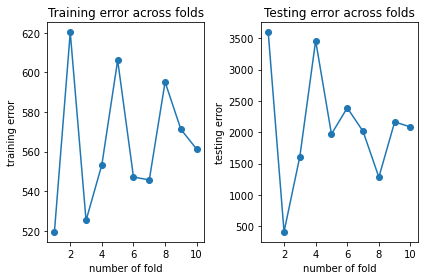

In [73]:
plt.subplot(1,2,1)
plt.plot(range(1, kf.get_n_splits() + 1), np.array(list_training_error).ravel(), "o-")
plt.xlabel("number of fold")
plt.ylabel("training error")
plt.title("Training error across folds")
plt.tight_layout()
plt.subplot(1,2,2)
plt.plot(range(1, kf.get_n_splits() + 1), np.array(list_testing_error).ravel(), "o-")
plt.xlabel("number of fold")
plt.ylabel("testing error")
plt.title("Testing error across folds")
plt.tight_layout()
plt.show()

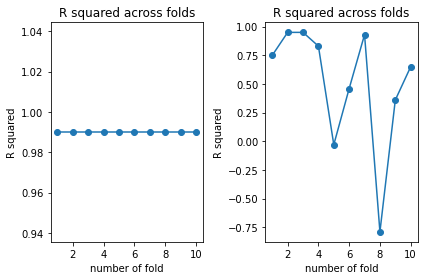

In [74]:
plt.subplot(1,2,1)
plt.plot(range(1, kf.get_n_splits() + 1), np.array(r_squared_train).ravel(), "o-")
plt.xlabel("number of fold")
plt.ylabel("R squared")
plt.title("R squared across folds")
plt.tight_layout()
plt.subplot(1,2,2)
plt.plot(range(1, kf.get_n_splits() + 1), np.array(r_squared_test).ravel(), "o-")
plt.xlabel("number of fold")
plt.ylabel("R squared")
plt.title("R squared across folds")
plt.tight_layout()
plt.show()

In [75]:
print(f"""TRAINING SET DATA (on average):
R Squared: {mean(r_squared_train)}
Mean Absolute Error: {mean(list_training_error)}

TESTING SET DATA (on average):
R Squared: {mean(r_squared_test)}
Mean Absolute Error: {mean(list_testing_error)}
""")

TRAINING SET DATA (on average):
R Squared: 0.99
Mean Absolute Error: 564.4889723618278

TESTING SET DATA (on average):
R Squared: 0.506
Mean Absolute Error: 2098.5272915363944




**Observation:** K-fold cross validation wasn't as helpful in this case due to the data being ordered by CarName, meaning that losing a section at a time meant a significant loss of data for training (eg all low value cars).

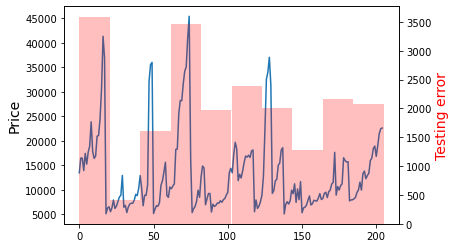

In [76]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(output)
# set y-axis label
ax.set_ylabel("Price",fontsize=14)


bar_data = list_testing_error
bar_width = len(output)/n_splits
x_data = [x*bar_width + bar_width/2 for x in range(ceil(0.5*len(output)/n_splits)-1)]

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.bar(
    x_data,
    np.array(bar_data).ravel(),
    color="red", 
    width=(len(output)+bar_width/2)/n_splits*0.95, 
    alpha = 0.25
)
ax2.set_ylabel("Testing error",color="red",fontsize=14)
plt.show()

**Observations**: Testing error increases dramatically when segments with the highest value cars are removed from the training set to be set aside for testing purposes.

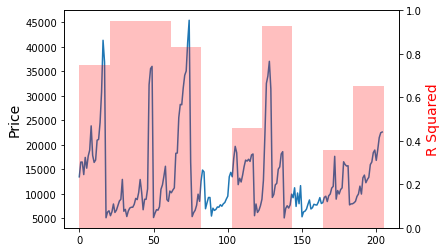

In [77]:

# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(output)
# set y-axis label
ax.set_ylabel("Price",fontsize=14)


bar_data = r_squared_test
bar_width = len(output)/n_splits
x_data = [x*bar_width + bar_width/2 for x in range(ceil(0.5*len(output)/n_splits)-1)]

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.bar(
    x_data,
    np.array(bar_data).ravel(),
    color="red", 
    width=(len(output)+bar_width/2)/n_splits*0.95, 
    alpha = 0.25
)
ax2.set_ylim([0, 1])
ax2.set_ylabel("R Squared",color="red",fontsize=14)
plt.show()

**Observations**: The R squared score is greatly reduced and even turns negative when large swathes of low value cars are removed from the training data.

*Because R-square is defined as the proportion of variance explained by the fit, if the fit is actually worse than just fitting a horizontal line then R-square is negative.*

For these reasons, in this notebook I've opted to use randomly selected data from the `train_test_split` function, averaged over several iterations to get the most accurate evaluation of my models.